# 2. Data wrangling & cleaning

## 2.1 Importing libraries, options

In [1]:
import pandas as pd
import regex as re
import numpy as np
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)

## 2.2 Reading and merging datasets

In [2]:
regions = ['north','north_centre','big_capitals','south_centre','south','east']
cars = pd.concat(map(lambda region: pd.read_csv('../data/'+region+'.csv'), regions),axis=0).reset_index(drop=True)


## 2.3 Duplicates & inconsistent data

In [3]:
# I first was dropping duplicates of column ID, but this might be a bad thing to do since
# we would lose the location information. Instead, I will train the model with all data, but
# I will later test it only with a clean test set without duplicates. 

#cars = cars.drop_duplicates(subset=['id']).reset_index(drop=True)
# 7560603 is an example of a duplicated car. 

In [4]:
# Dropping unique identifiers and repeated columns.
cars = cars.drop(['link','transmission','seller','warranty','autonomy'], axis=1)
# I also drop 'Autonomy', 'seller' and 'warranty' because they end up having no
# variance, and we want to avoid overfitting.


## 2.3 Formatting numerical features

In [5]:
# 'Nuevo' stands for 'New' in spanish. They are not second-hand cars and thus do not belong into our model.
cars = cars[cars['km']!='NUEVO'].copy().reset_index(drop=True)

In [6]:
# Using regex (Regular expression) to remove units and text.
cars['cv'] = cars['cv'].map(lambda x: re.findall(r'\d+',x)[0])
cars['km'] = cars['km'].map(lambda x: re.findall(r'\d*', x.replace('.',''))[0])
cars['doors'] = cars['doors'].map(lambda x: re.findall(r'\d+',x)[0])
cars['emissions'] = cars['emissions'].map(lambda x: re.findall(r'\d+',x)[0])
cars['year'] = cars['year'].map(lambda x: re.findall(r'[\d]{4}',x)[0])

# Computing the age of each car.
cars['year'] = (datetime.date.today().year - pd.to_datetime(cars['year']).dt.year)

# Correcting some formats to numerical.
cars['cv'] = pd.to_numeric(cars['cv'], errors='coerce')
cars['km'] = pd.to_numeric(cars['km'], errors='coerce')
cars['doors'] = pd.to_numeric(cars['doors'], errors='coerce')
cars['emissions'] = pd.to_numeric(cars['emissions'], errors='coerce')

In [7]:
# There is a small but significant amount of inconsistent data. Some cars were 
# posted without all of its features listed, and the web print those as the number 0. 
# None of the features are compatible with zero value (it makes no sense to have a max
# speed of 0, 0 seats, etc). There are two exceptions (years and marchas), but we are
# those only affect to either brand new or electric cars, which fall outside of our scope.

# Summing up: we remove any row that has a null feature. 
cars = cars[(cars!=0).all(axis=1)].reset_index(drop=True)

## 2.3 Unifying categorical values

In [8]:
def clean_color(car):
    if 'blanco' in car:
        return 'White'
    elif 'negro' in car:
        return 'Black'
    elif 'gris' in car:
        return 'Gray'
    elif ('marrón' in car)|('marron' in car):
        return 'Brown'
    elif 'azul' in car:
        return 'Blue'
    elif ('rojo' in car)|('granate' in car):
        return 'Red'
    elif ('plateado' in car)|('plata' in car):
        return 'Silver'
    elif 'verde' in car:
        return 'Green'
    elif 'naranja' in car:
        return 'Orange'
    elif ('amarillo' in car)|('oro' in car):
        return 'Yellow'
    elif 'beige' in car:
        return 'Beige'
    else:
        return 'Other'
    
def clean_cilindros(car):
    n = int(re.findall(r'\d+',car)[0])
    if 'en línea' in car:
        if n == 4:
            return '4 inline'
        elif n<4:
            return 'more4 inline'
        elif n>4:
            return 'less4 inline'
    elif 'en v' in car:
        if n == 6:
            return '6 V'
        else:
            return 'more6 V'
    elif 'en boxer' in car:
        return 'boxer'
    else:
        return 'other'
    
def clean_gearbox(car):
    if 'manual' in car:
        return 'Manual'
    else:
        return 'Automatic'
    
def clean_location(car):
    if 'Rioja' in car:
        return 'La Rioja'
    elif 'Ciudad+real' in car:
        return 'Ciudad Real'
    elif 'Palmas+las' in car:
        return 'Las Palmas'
    elif 'Illes+balears' in car:
        return 'Islas Baleares'
    elif 'Coruna' in car:
        return 'Coruña'
    else:
        return car
    
def clean_fuel(car):
    if 'Híbrido' in car:
        return 'Hybrid'
    elif 'Gasolina' in car:
        return 'Gasoline'
    elif 'Diesel' in car:
        return car
    elif 'Eléctrico' in car:
        return car


In [9]:
# Some cars have no information about their color (NaN).
cars = cars[~cars['color'].isna()].copy() # They are a small %, I remove them.

# Unifying categories.
cars['color']=cars['color'].map(clean_color)
cars['gearbox']=cars['gearbox'].map(clean_gearbox)
cars['cylinders'] = cars['cylinders'].map(clean_cilindros)

# Combining brands with a count smaller than <threshold> into "other".
threshold = 9
other_brands = cars['brand'].value_counts()[cars['brand'].value_counts().values<threshold].index
cars['brand'] = np.where(cars['brand'].isin(other_brands), 'Other',cars['brand'])


In [10]:
cars['class'] = cars['class'].map(lambda x: x.capitalize())
cars['location'] = cars['location'].map(lambda x: x.capitalize())
cars['location']=cars['location'].map(clean_location)

cars['brand'] = np.where(cars['brand']=='Bmw','BMW',cars['brand'])


## 2.5 Target correlation 

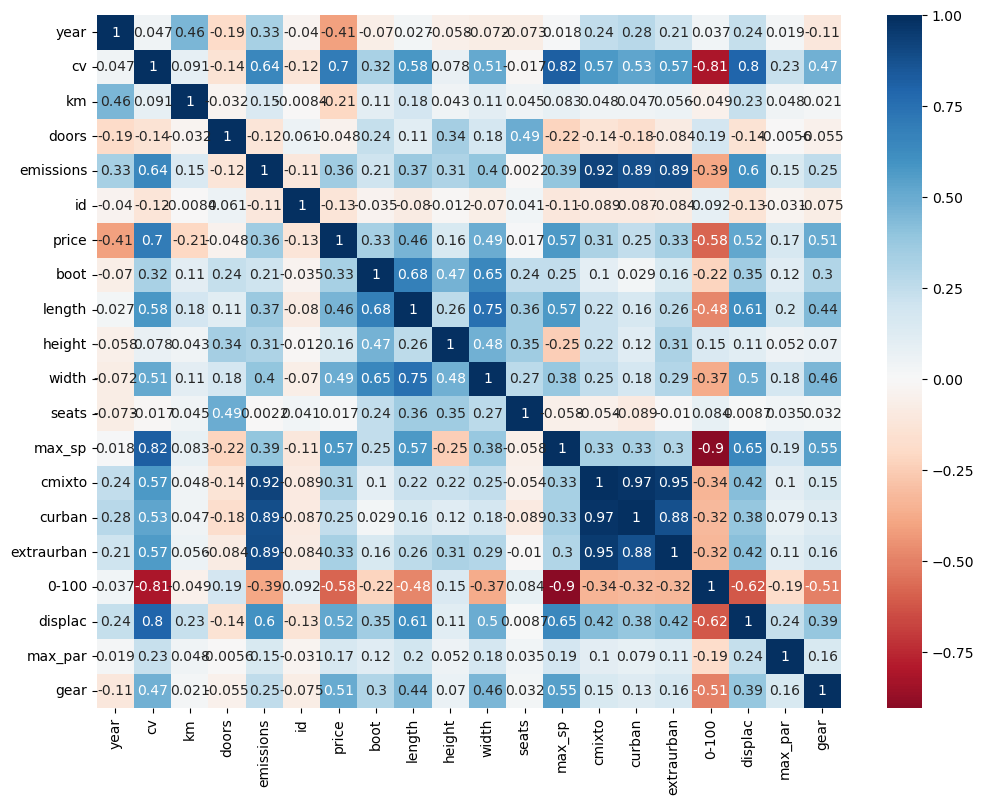

In [11]:
plt.figure(figsize=(12,9))
sns.heatmap(cars.select_dtypes(np.number).corr(), annot=True, cmap='RdBu', center = 0)
plt.show()

<!> We could also reduce LENGHT and WIDTH, which are correlated, to one feature by multiplying one times the other (horizontal area).



In [12]:
# We can see "cmixto", "curban" and "extraurban" are features highly correlated.
# I will keep cmixto, since it's the one with the highest correlations with its
# peers (in fact it's defined as the mean of both).
cars = cars.drop(['curban','extraurban','emissions'], axis=1)

# I must remove  either 0-100 or max speed, high correlation. 
cars = cars.drop(['max_sp'], axis=1)

# Dropping electric cars since there're not enough of them
cars = cars[cars['fuel']!='Eléctrico']
cars['fuel']=cars['fuel'].map(clean_fuel)


In [13]:
# Width and length are correlated. Insteada of dropping one I will create a new
# variable out of the two: the horizontal area (multiplicating both)
cars['area'] = cars['width']*cars['length']
cars = cars.drop(['width','length'], axis=1)

In [14]:
# Through feature selection I drop all of these features with low correlations, that are redundant
# and make the model overfit. 
cars = cars.drop(['doors','height','seats','0-100','displac','cylinders','max_par','gear','boot'], axis=1)

In [15]:
cars.to_csv('../data/clean_cars_id.csv',index=False)

In [16]:
cars.drop(['id'],axis=1).to_csv('../data/clean_cars.csv',index=False)

In [17]:
# I did not expect to see such an expensive car
cars[cars['price']==198990]

,year,cv,km,fuel,gearbox,color,id,brand,price,cmixto,class,location,area
97193,13,571,33350,Gasoline,Automatic,Other,2839494,Mercedes,198990,13.2,Sport,Madrid,90016


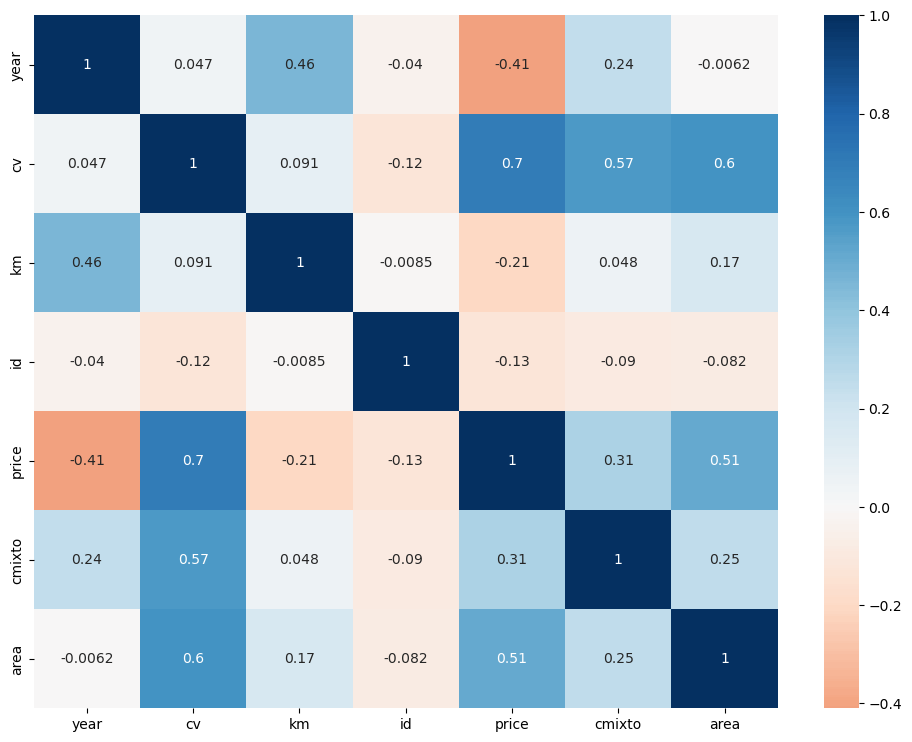

In [18]:
# Final plot of correlations
plt.figure(figsize=(12,9))
sns.heatmap(cars.select_dtypes(np.number).corr(), annot=True, cmap='RdBu', center = 0)
plt.show()